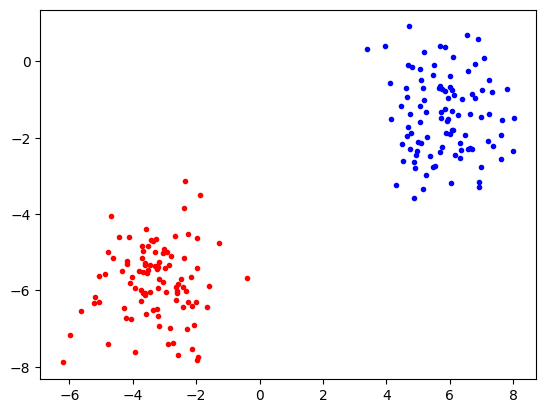

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=200, centers=2)
idxs_1 = np.argwhere(y==1)
idxs_0 = np.argwhere(y==0)
X1 = X[np.reshape(idxs_1, idxs_1.size)]
X0 = X[np.reshape(idxs_0, idxs_0.size)]

plt.plot(X0[:,0], X0[:,1], 'b.', X1[:,0], X1[:,1], 'r.')

In [ ]:
class SVM:
    """ 
    A regularized kernel SVM 
    
    ...

    Attributes
    ----------
    C : float
        The inverse regularization parameter
    kernel: str
        The kernel type (e.g. linear, gaussian_rbf, etc..)

    Methods
    -------
    train(X,y):
        Trains the model on the dataset (X,y)

    predict(q):
        Makes a prediction about query point q
    """
    def __init__(self, C, kernel="linear"):
        self.C = C
        self.kernel = kernel
    
    def train(self, X, y):
        """ Train the classifier using the SMO algorithm """
        N, D = X.shape
        
        # TODO Use representer theorem to convert alpha to weights

    def predict(self, q):
        # TODO Use representer theorem t